# 2.5 CNN Coding Assignment/Coding Assignment 2.6

## Setup

Here, I will import the libraries needed for the following: 

1. Set a random seed for consistency 
2. Define training settings for the following: 
 
     a. Image size 
 
     b. Batch size 
 
     c. Epochs.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TensorFlow:", tf.__version__)

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 30

# Code used to set the relative path to the dataset location
DATA_DIR = "cifar10-64"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

TensorFlow: 2.19.1


## Loading cifar10-64 dataset

The dataset is stored in **cifar10-64/train** and **cifar10-64/test**.

There is no separate validation folder, so I split validation from the training folder using **validation_split**.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Datasets loaded.")
print("Classes:", class_names)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.
Datasets loaded.
Classes: ['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']


## Normalize images and improving performance

Here, I will normalize pixel values to the range [0, 1]. I will also use prefetch() to speed training up.

-If the first epoch feels slow, that should be normal! TensorFlow in terms **Warms Up** and builds the pipeline.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def normalize_img(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize_img, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

print("Normalization + prefetch done.")

Normalization + prefetch done.


## Data sanity check

Here, I am displaying a few training images, so we can confirm the dataset loads correctly and the labels match class folders.

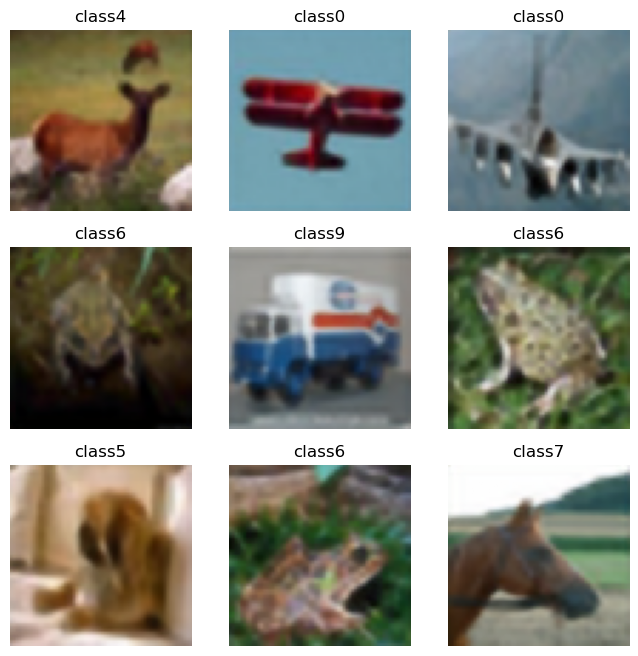

In [9]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
plt.show()

## Data augmentation (Concerning training)

I will be apply lightweight augmentation during training concerning: 

-Flip 

-Rotate 

-Zoom 

-Contrast

In [11]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", seed=SEED),
        tf.keras.layers.RandomRotation(0.08, seed=SEED),
        tf.keras.layers.RandomZoom(0.10, seed=SEED),
        tf.keras.layers.RandomContrast(0.10, seed=SEED),
    ],
    name="augmentation"
)

## Build CNN model 

-Stride = 2 instead of MaxPooling

Here as instructed, We are replacing MaxPooling layers by inserting a Conv2D with stride=2 at each of the 3 convolution levels. This keeps BatchNorm between convolution layers. 

I also used a HeNormal initializer and applied it to all Conv2D and Dense layers.

In [14]:
initializer = tf.keras.initializers.HeNormal()

def conv_bn(x, filters, stride=1):
    x = tf.keras.layers.Conv2D(
        filters,
        (3, 3),
        strides=stride,
        padding="same",
        activation="relu",
        kernel_initializer=initializer
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def build_model(input_shape=(64, 64, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # augmentation runs only during training
    x = data_augmentation(inputs)

    # Conv Level 1 (stride-2 conv instead of MaxPool)
    x = conv_bn(x, 64, stride=1)
    x = conv_bn(x, 64, stride=1)
    x = conv_bn(x, 64, stride=1)
    x = conv_bn(x, 64, stride=2)

    # Conv Level 2
    x = conv_bn(x, 128, stride=1)
    x = conv_bn(x, 128, stride=1)
    x = conv_bn(x, 128, stride=1)
    x = conv_bn(x, 128, stride=2)

    # Conv Level 3
    x = conv_bn(x, 256, stride=1)
    x = conv_bn(x, 256, stride=1)
    x = conv_bn(x, 256, stride=1)
    x = conv_bn(x, 256, stride=2)

    # Classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=initializer)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer=initializer
    )(x)

    model = tf.keras.Model(inputs, outputs, name="cifar10_64_stride_cnn")
    return model

model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(class_names))
model.summary()

Model: "cifar10_64_stride_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,770,122 (10.57 MB)

 Trainable params: 2,766,538 (10.55 MB)

 Non-trainable params: 3,584 (14.00 KB)

## Compiling and training 30 epochs

Here, I will compile the model and train for 30 epochs, and tracking accuracy and validation accuracy.

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 526s 835ms/step - accuracy: 0.3947 - loss: 1.6525 - val_accuracy: 0.7740 - val_loss: 0.7121 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 532s 852ms/step - accuracy: 0.5612 - loss: 1.2285 - val_accuracy: 0.7303 - val_loss: 0.7922 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 531s 850ms/step - accuracy: 0.6212 - loss: 1.0607 - val_accuracy: 0.6159 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 534s 855ms/step - accuracy: 0.6741 - loss: 0.9264 - val_accuracy: 0.7108 - val_loss: 0.8630 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 531s 850ms/step - accuracy: 0.7412 - loss: 0.7502 - val_accuracy: 0.8884 - val_loss: 0.3158 - learning_rate: 5.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 537s 860ms/step - accuracy: 0.7621 - loss: 0.6808 - val_accuracy: 0.9056 - val_loss: 0.2958 - learning_rate: 5.0000e-04
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 530s 848ms/step 

## Plot accuracy vs Val_accuracy

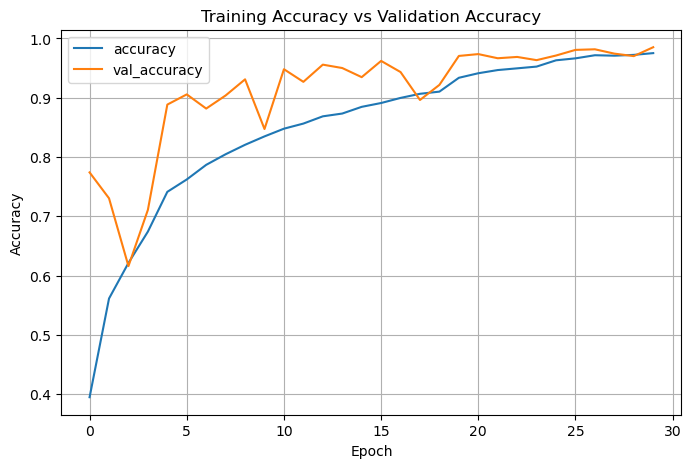

In [24]:
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])

plt.figure(figsize=(8, 5))
plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Testing set evaluation

Here, I evaluate model loss and accuracy using the test dataset and print the final test accuracy.

In [35]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Test Loss: 0.40739715099334717
Test Accuracy: 0.8924999833106995


## Reflection

You can see that replacing MaxPooling with stride=2 convolution layers worked as expected. Instead of just taking the maximum value, the model was able to learn how to downsample the feature maps. This gave the network more flexibility when extracting features from the images.

You were also able to observe how training accuracy and validation accuracy behaved over time. If training accuracy increases much faster than validation accuracy, that can indicate overfitting. Here, the two stayed relatively close, which shows the model was generalizing fairly well.

The data augmentation pipeline included flips, rotations, zoom, and contrast adjustments. These transformations helped create variation in the training data without damaging the content of the images. Seeing these variations helped improve generalization and reduced overfitting.

The final test accuracy was 89.25%.